In [12]:
from Bio.Blast import NCBIWWW

from Bio.Blast.Applications import NcbiblastpCommandline
from io import StringIO 
from Bio.Blast import NCBIXML
from Bio.Blast import NCBIWWW

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

import numpy
import time

In [13]:
s = SeqIO.parse('kinase_domains.txt', 'fasta') # single sequence fasta file
# for i,thing in enumerate(s):
#     print(thing,"\n")

In [14]:
# n = 0
# with open('kinase_domains.txt', 'r') as f:
#     for line in f:
#         n += 1
#         print(line.strip(),"\n")

In [15]:
lines = []
with open('kinase_domains.txt', 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            lines.append(line)

fam_to_seqs = {}
seqs = []
fams = []

isKinase = False
kinase = False
for line in lines:
    
    if line[0]=='>':
        if kinase:
            seqs.append(seq)
            fams.append(kinase)
            if kinase in fam_to_seqs.keys():
                fam_to_seqs[kinase].append(seq)
            else:
                fam_to_seqs[kinase] = [seq]
        isKinase = True
        kinase = line[line.find(':')+1:]
        kinase = kinase[:kinase.find(':')]
        seq = ''
    else:
        isKinase = False
        seq = seq + line

In [16]:
seqs = numpy.array((list(set((seqs)))))
fams = numpy.array((list(set(fams))))

In [17]:
len(seqs)

530

In [22]:
start = time.time()
s = start
alignments = numpy.full((len(seqs),len(seqs)),-1.0)

for i,seq_train in enumerate(seqs):
    seq_train = ''.join([x for x in seq_train])
    seq_train = seq_train.replace('-',' ')
    
    if i%2==0:
        print ('iter %d | %5.3f secs' % (i, time.time()-start) )
        start = time.time()
    seq_train = SeqRecord(Seq(seq_train), id="seq_train")
    SeqIO.write(seq_train, "seq_train.fasta", "fasta")
    
    for j,seq_test in enumerate(seqs):
        
        if alignments[i][j] != -1 or i==j:
            continue
            
        seq_test = ''.join([x for x in seq_test])
        seq_test = seq_test.replace('-',' ')

        blastp_cline = NcbiblastpCommandline(subject = 'seq_train.fasta', outfmt=5, 
                                             cmd='ncbi_blast/bin/blastp') #Blast command
        out, err = blastp_cline(seq_test)
        blast_result_record = NCBIXML.read(StringIO(out))
        
        maxIdentity = 0.0
        
        if not blast_result_record.alignments:
            continue
        for alignment in blast_result_record.alignments:
            for hsp in alignment.hsps:
                if (hsp.identities/ hsp.align_length) >= maxIdentity:
                    maxIdentity = (hsp.identities/ hsp.align_length)
        
#         print(type(maxIdentity))
        alignments[i][j] = maxIdentity
#         break
        
        
print ('Total time: %5.3f secs' % (time.time()-s) )

iter 0 | 0.002 secs
iter 2 | 34.170 secs
iter 4 | 31.502 secs
iter 6 | 31.048 secs
iter 8 | 31.094 secs
iter 10 | 30.941 secs
iter 12 | 30.346 secs
iter 14 | 29.984 secs
iter 16 | 31.326 secs
iter 18 | 30.603 secs
iter 20 | 31.275 secs
iter 22 | 31.346 secs
iter 24 | 31.612 secs
iter 26 | 30.930 secs
iter 28 | 31.351 secs
iter 30 | 31.210 secs
iter 32 | 31.422 secs
iter 34 | 30.934 secs
iter 36 | 31.103 secs
iter 38 | 30.956 secs
iter 40 | 31.124 secs
iter 42 | 30.795 secs
iter 44 | 31.068 secs
iter 46 | 31.454 secs
iter 48 | 31.199 secs
iter 50 | 31.021 secs
iter 52 | 31.217 secs
iter 54 | 30.985 secs
iter 56 | 30.820 secs
iter 58 | 31.330 secs
iter 60 | 31.084 secs
iter 62 | 31.065 secs
iter 64 | 31.435 secs
iter 66 | 30.997 secs
iter 68 | 30.934 secs
iter 70 | 30.149 secs
iter 72 | 31.151 secs
iter 74 | 31.237 secs
iter 76 | 31.157 secs
iter 78 | 31.371 secs
iter 80 | 30.088 secs
iter 82 | 31.584 secs
iter 84 | 30.787 secs
iter 86 | 30.761 secs
iter 88 | 30.653 secs
iter 90 | 31.386

In [28]:
seq_train

SeqRecord(seq=Seq('FEERPFAAASIGQVHLARMKGGREVAMKIQYPGVAQSINSDVNNLMAVLNMSNM...AMF'), id='seq_train', name='<unknown name>', description='<unknown description>', dbxrefs=[])

In [25]:
fams

array(['Aur', 'DMPK', 'SRPK', 'ALK', 'WEE', 'Slob', 'SgK493', 'STE20',
       'MLK', 'PKG', 'Ret', 'Bud32', 'Musk', 'CAMK2', 'FGFR', 'STK33',
       'RIO', 'Axl', 'RSK', 'PSK', 'RAD53', 'KIS', 'PIM', 'NKF5',
       'TK-Unique', 'Akt', 'PDK1', 'MAPKAPK', 'TLK', 'DYRK', 'Tie', 'Ack',
       'EGFR', 'SGK', 'CDK', 'LRRK', 'NRBP', 'InsR', 'DDR', 'Lmr', 'CASK',
       'NKF3', 'CDKL', 'CAMKK', 'GSK', 'STE11', 'PLK', 'TTBK', 'NDK',
       'TSSK', 'SCY1', 'GRK', 'Other-Unique', 'NDR', 'NAK', 'Ryk', 'LISK',
       'FJ', 'Jak', 'PAN3', 'CAMK-Unique', 'NEK', 'DCAMKL', 'Haspin',
       'STE-Unique', 'PKC', 'PKD', 'CK1', 'Ror', 'Trk', 'VPS15', 'STE7',
       'PHK', 'CAMK1', 'MLCK', 'Tec', 'DAPK', 'PKN', 'STKR', 'Met',
       'SgK495', 'TOPK', 'Csk', 'PDGFR', 'TTK', 'ULK', 'RGC', 'Eph',
       'BUB', 'IKK', 'NKF1', 'IRE', 'MOS', 'SgK071', 'Alpha', 'CLK',
       'RSKR', 'Abl', 'MAPK', 'PEK', 'RIPK', 'Src', 'RCK', 'VRK', 'Trbl',
       'Fer', 'Trio', 'TBCK', 'RSKL', 'CAMKL', 'ABC1', 'NKF4', 'CCK4',
   

In [24]:
alignments

array([[-1.        ,  0.5       ,  0.2278481 , ...,  0.5       ,
         0.27350427,  0.4       ],
       [ 0.5       , -1.        ,  0.25239617, ...,  0.33333333,
         0.4       ,  0.5       ],
       [ 0.2278481 ,  0.25239617, -1.        , ...,  0.20588235,
         0.2195122 ,  0.31578947],
       ...,
       [ 0.5       ,  0.33333333,  0.20588235, ..., -1.        ,
        -1.        ,  0.32432432],
       [ 0.34586466,  0.4       ,  0.2195122 , ..., -1.        ,
        -1.        ,  0.32      ],
       [ 0.4       ,  0.5       ,  0.31578947, ...,  0.32432432,
         0.30769231, -1.        ]])

In [23]:
!which blastp

In [29]:
import pandas
df = pandas.DataFrame(alignments,dtype=float)
# df.to_csv('data_dev/fam_alignments.csv',header=fams,index_label=fams)

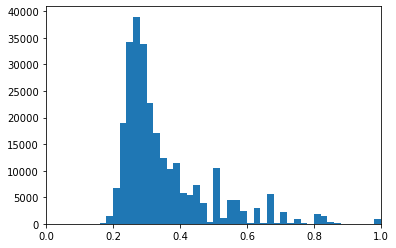

In [42]:
import numpy as np
import matplotlib.pyplot as plt

toPlot = alignments.flatten()
plt.hist(toPlot,bins=100)
plt.xlim(0,1)
plt.show()

In [34]:
from itertools import combinations 
from itertools import product 

famPair_to_kinaseDistances = {tuple((pair[0],pair[1])):[] for pair in combinations(fams,2)}

for pair in combinations(fams,2):
    
    fam1 = pair[0]
    fam2 = pair[1]
    
    seqList1 = fam_to_seqs[fam1]
    seqList2 = fam_to_seqs[fam2]
        
    for pair2 in product(seqList1,seqList2):
        
        seq1 = pair2[0]
        seq2 = pair2[1]
        
        seqIdx1 = numpy.where(seqs==seq1)[0][0]
        seqIdx2 = numpy.where(seqs==seq2)[0][0]
        
        distance = alignments[seqIdx1][seqIdx2]
        if distance < 0 and distance > -1:
            print(distance)
        
        if distance == -1.0:
            continue

        famPair_to_kinaseDistances[tuple((fam1,fam2))].append(distance)
        
#         print(fam1,kinase1,fam2,kinase2,distance)

In [35]:
famDistanceMatrix = numpy.full((len(fams),len(fams)),-1.0)

for k,v in famPair_to_kinaseDistances.items():
    toAvg = list(set(v))
    if 'PKA' in k and 'CK2' in k:
        print(k,toAvg,fam_to_seqs[k[0]],fam_to_seqs[k[1]])
    toAvg = numpy.array((v))
    toAvg = toAvg[toAvg < 1.0]

#     if 1 in v and 'PKA' in k:
#         print(k,v)
    avgDistance = numpy.median(toAvg)
    
    if 'PKA' in k and 'CK2' in k:
        print(k,avgDistance)

    fIdx1 = numpy.where(fams==k[0])[0][0]
    fIdx2 = numpy.where(fams==k[1])[0][0]
    famDistanceMatrix[fIdx1][fIdx2] = avgDistance
    
for i,row in enumerate(famDistanceMatrix):
    for j,val in enumerate(row):
        famDistanceMatrix[j][i] = famDistanceMatrix[i][j]
        
for i,row in enumerate(famDistanceMatrix):
    for j,val in enumerate(row):
        if i==j:
            famDistanceMatrix[i][j] = 1
        elif val == -1:
            famDistanceMatrix[i][j] = 0

/home/k4thryn/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/k4thryn/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


('CK2', 'PKA') [0.3076923076923077, 0.5714285714285714, 0.6, 0.31, 0.29457364341085274] ['YQLVRKLGRGKYSEVFEAINITNNEKVVVKILKPVKKKKIKREIKILENLRGGPNIITLADIVKDPVSRTPALVFEHVNNTDFKQLYQTLTDYDIRFYMYEILKALDYCHSMGIMHRDVKPHNVMIDHEHRKLRLIDWGLAEFYHPGQEYNVRVASRYFKGPELLVDYQMYDYSLDMWSLGCMLASMIFRKEPFFHGHDNYDQLVRIAKVLGTEDLYDYIDKYNIELDPRFNDILGRHSRKRWERFVHSENQHLVSPEALDFLDKLLRYDHQSRLTAREAMEHPYF', 'YQLVRKLGRGKYSEVFEAINITNNERVVVKILKPVKKKKIKREVKILENLRGGTNIIKLIDTVKDPVSKTPALVFEYINNTDFKQLYQILTDFDIRFYMYELLKALDYCHSKGIMHRDVKPHNVMIDHQQKKLRLIDWGLAEFYHPAQEYNVRVASRYFKGPELLVDYQMYDYSLDMWSLGCMLASMIFRREPFFHGQDNYDQLVRIAKVLGTEELYGYLKKYHIDLDPHFNDILGQHSRKRWENFIHSENRHLVSPEALDLLDKLLRYDHQQRLTAKEAMEHPYF'] ['FERIKTLGTGSFGRVMLVKHKETGNHYAMKILDKQKVVKLKQIEHTLNEKRILQAVNFPFLVKLEFSFKDNSNLYMVMEYVPGGEMFSHLRRIGRFSEPHARFYAAQIVLTFEYLHSLDLIYRDLKPENLLIDQQGYIQVTDFGFAKRVKGRTWTLCGTPEYLAPEIILSKGYNKAVDWWALGVLIYEMAAGYPPFFADQPIQIYEKIVSGKVRFPSHFSSDLKDLLRNLLQVDLTKRFGNLKNGVNDIKNHKWF', 'FERKKTLGTGSFGRVMLVKHKATEQYYAMKILDKQKVVKLKQIEHTLNEKRILQAVNFPFLVRLEYAFKD

/home/k4thryn/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/k4thryn/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


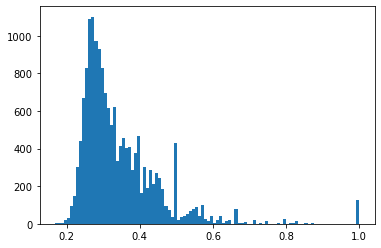

In [36]:
toPlot = famDistanceMatrix[famDistanceMatrix!=0]

plt.hist(toPlot,bins=100)
plt.show()

In [37]:
someKs = ['MAPK', 'Src','PKC','PKA','CDK','CK2']

for pair in combinations(someKs,2):
    i = numpy.where(fams==pair[0])[0][0]
    j = numpy.where(fams==pair[1])[0][0]
    p = famDistanceMatrix[i][j]
    if p==-1:
        p = famDistanceMatrix[j][i]
    print(pair[0],pair[1],p)

MAPK Src 0.2899576704130784
MAPK PKC 0.30795574288724975
MAPK PKA 0.30668473351400183
MAPK CDK 0.3473699763593381
MAPK CK2 0.28783747227181733
Src PKC 0.26666666666666666
Src PKA 0.2684563758389262
Src CDK 0.28870549481356883
Src CK2 0.2395428377201368
PKC PKA 0.4
PKC CDK 0.28125
PKC CK2 0.27879114948731787
PKA CDK 0.29207920792079206
PKA CK2 0.4407142857142857
CDK CK2 0.2897811447811448


In [ ]:
MAPK Src 0.2899576704130784
MAPK PKC 0.30852135374697826
MAPK PKA 0.30668473351400183
MAPK CDK 0.3473699763593381
MAPK CK2 0.30478424850770647
Src PKC 0.26666666666666666
Src PKA 0.2684563758389262
Src CDK 0.28870549481356883
Src CK2 0.238510101010101
PKC PKA 0.4
PKC CDK 0.28125
PKC CK2 0.32236227824463115
PKA CDK 0.2914572864321608
PKA CK2 0.4407142857142857
CDK CK2 0.294635916040425

In [39]:
import numpy
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
import Levenshtein
from Levenshtein import hamming
from itertools import combinations
import matplotlib.pyplot as plt
import math
import random
from Bio import pairwise2
from Bio import Align
from Bio.SubsMat import MatrixInfo
import sklearn.cluster
import itertools
import time

/home/k4thryn/anaconda3/lib/python3.8/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [41]:
alignments2 = numpy.full((len(seqs),len(seqs)),-1.0)

aligner = Align.PairwiseAligner()
aligner.substitution_matrix = MatrixInfo.blosum62 #MatrixInfo.  pam30
aligner.mode = 'local'

for i,seq1 in enumerate(seqs):  
    if i%2==0:
        print ('iter %d | %5.3f secs' % (i, time.time()-start) )
        start = time.time()
    for j,seq2 in enumerate(seqs):
        
        
        if alignments2[j][i] != -1: # or i==j:
            continue
        if len(seq1)==3 or len(seq2)==3:
#             print("fsdfdfs:",seq1,seq2)
            continue
        score = aligner.align(seq1,seq2).score
#         print(score)
        alignments2[i][j] = score
        alignments2[j][i] = score

ValueError: expected a matrix

In [260]:
alignments2

array([[1370.,  686.,  650., ...,  384.,  628.,  633.],
       [ 686., 1499.,  663., ...,  435.,  668.,  673.],
       [ 650.,  663., 1391., ...,  396.,  631.,  620.],
       ...,
       [ 384.,  435.,  396., ...,  721.,  387.,  425.],
       [ 628.,  668.,  631., ...,  387., 1395.,  650.],
       [ 633.,  673.,  620., ...,  425.,  650., 1845.]])

[1370.  686.  650. ...  425.  650. 1845.]


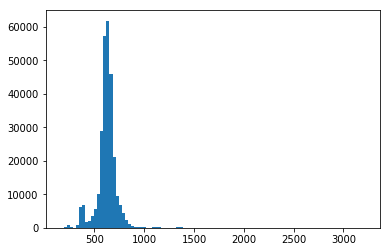

In [261]:
import numpy as np
import matplotlib.pyplot as plt

toPlot = alignments2.flatten()
toPlot = toPlot[toPlot != -1]

print(toPlot)

plt.hist(toPlot,bins=100)
plt.show()

In [263]:
from itertools import combinations 
from itertools import product 

famPair_to_kinaseDistances2 = {tuple((pair[0],pair[1])):[] for pair in combinations(fams,2)}

for pair in combinations(fams,2):
    fam1 = pair[0]
    fam2 = pair[1]
    seqList1 = fam_to_seqs[fam1]
    seqList2 = fam_to_seqs[fam2]
        
    for pair2 in product(seqList1,seqList2): 
        seq1 = pair2[0]
        seq2 = pair2[1]
        seqIdx1 = numpy.where(seqs==seq1)[0][0]
        seqIdx2 = numpy.where(seqs==seq2)[0][0]
        
        distance = alignments2[seqIdx1][seqIdx2]
        if distance < 0 and distance > -1:
            print(distance)
        if distance == -1.0:
            continue

        famPair_to_kinaseDistances2[tuple((fam1,fam2))].append(distance)
        

dupFamTups = [tuple((f,f)) for f in fams]
for ff in dupFamTups:
    famPair_to_kinaseDistances2[ff] = []

for pair in dupFamTups:
    fam1 = pair[0]
    fam2 = pair[1]
    seqList1 = fam_to_seqs[fam1]
    seqList2 = fam_to_seqs[fam2]
        
    for pair2 in product(seqList1,seqList2):
        seq1 = pair2[0]
        seq2 = pair2[1]
        seqIdx1 = numpy.where(seqs==seq1)[0][0]
        seqIdx2 = numpy.where(seqs==seq2)[0][0]
        
        distance = alignments2[seqIdx1][seqIdx2]
        if distance < 0 and distance > -1:
            print(distance)
        if distance == -1.0:
            continue

        famPair_to_kinaseDistances2[tuple((fam1,fam2))].append(distance)      
        
        
        
        
        
        

famDistanceMatrix2 = numpy.full((len(fams),len(fams)),-1.0)

for k,v in famPair_to_kinaseDistances2.items():
    toAvg = list(set(v))
#     if 'PKA' in k and 'CK2' in k:
#         print(k,toAvg,fam_to_seqs[k[0]],fam_to_seqs[k[1]])
    toAvg = numpy.array((v))
    avgDistance = numpy.mean(toAvg)
    fIdx1 = numpy.where(fams==k[0])[0][0]
    fIdx2 = numpy.where(fams==k[1])[0][0]
    famDistanceMatrix2[fIdx1][fIdx2] = avgDistance
    
for i,row in enumerate(famDistanceMatrix):
    for j,val in enumerate(row):
        famDistanceMatrix2[j][i] = famDistanceMatrix2[i][j]
        
for i,row in enumerate(famDistanceMatrix2):
    for j,val in enumerate(row):
#         if i==j:
#             famDistanceMatrix2[i][j] = 1
        if val == -1:
            famDistanceMatrix2[i][j] = 0

In [38]:
someKs = ['MAPK', 'Src','PKC','PKA','CDK','CK2']
dups = [[f,f] for f in someKs]

for pair in combinations(someKs,2):
    i = numpy.where(fams==pair[0])[0][0]
    j = numpy.where(fams==pair[1])[0][0]
    p = famDistanceMatrix2[i][j]
    print(pair[0],pair[1],p)
for pair in dups:
    i = numpy.where(fams==pair[0])[0][0]
    j = numpy.where(fams==pair[1])[0][0]
    p = famDistanceMatrix2[i][j]
    print(pair[0],pair[1],p)

NameError: name 'famDistanceMatrix2' is not defined

In [266]:
maximum = numpy.max(famDistanceMatrix2)
minimum = numpy.min(famDistanceMatrix2)

famDistanceMatrix2_scaled = numpy.array((famDistanceMatrix2))
for i in range(len(fams)):
    for j in range(len(fams)):
        famDistanceMatrix2_scaled[i][j] = 1 - float(famDistanceMatrix2[i][j]-minimum)/(maximum-minimum) 

In [267]:
someKs = ['MAPK', 'Src','PKC','PKA','CDK','CK2','Akt']

for pair in combinations(someKs,2):
    i = numpy.where(fams==pair[0])[0][0]
    j = numpy.where(fams==pair[1])[0][0]
    p = famDistanceMatrix_pam[i][j]
    print(pair[0],pair[1],p)

MAPK Src 0.4334640322858291
MAPK PKC 0.42980573672768074
MAPK PKA 0.4420239848516726
MAPK CDK 0.3120735775900936
MAPK CK2 0.3497580475489165
MAPK Akt 0.4308015989901116
Src PKC 0.47611906993350295
Src PKA 0.5062471549069487
Src CDK 0.4330241187384045
Src CK2 0.4772794216093186
Src Akt 0.48009104297764094
PKC PKA 0.3435640648011783
PKC CDK 0.4212964911050331
PKC CK2 0.43220422189494356
PKC Akt 0.23207331042382595
PKA CDK 0.4396549547654114
PKA CK2 0.46371134020618565
PKA Akt 0.3034462444771724
CDK CK2 0.3588049652850832
CDK Akt 0.422806648432569
CK2 Akt 0.42636229749631815


In [268]:
famDistanceMatrix_pam = numpy.array((famDistanceMatrix2_scaled))

import pandas
df = pandas.DataFrame(famDistanceMatrix_pam,dtype=float)
df.to_csv('Final_data/famDistanceMatrix_pam_19.10.16.csv',header=None,index=None)

In [269]:
df = pandas.DataFrame(fams,dtype='U')
df.to_csv('Final_data/fams_forPamDistMatrix_19.10.16.csv',header=None,index=None)

In [257]:
len(fams)

129

In [273]:
famDistanceMatrix_pam[1][1]

0.5107686400446803